<a href="https://colab.research.google.com/github/csabiu/Astrostatistics/blob/main/Supernovae_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Among the following models, which model fits the Pantheon supernovae compilation better? why?
# $\Lambda$CDM, Flat $\Lambda$CDM, $w$CDM, Flat $w$CDM



In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.cosmology import FlatLambdaCDM, LambdaCDM, wCDM,FlatwCDM
from scipy import optimize
import pandas as pd

# These packages are not installed by default on Google Colab, we may need to
# install them
# I am using try/except so that we only install them if they're not already
# installed:
try:
   import emcee
except:
  # emcee not installed, install it and import
  !pip install emcee
  import emcee
# same for corner:
try:
  import corner
except:
  !pip install corner
  import corner

# same for dynesty:
try:
  from dynesty import NestedSampler
  from dynesty.utils import resample_equal
except:
  !pip install dynesty
  from dynesty import NestedSampler
  from dynesty.utils import resample_equal


models = ["FlatLCDM","LCDM",'FlatwCDM','wCDM']

In [68]:
z, mB, dmB = np.genfromtxt("https://raw.githubusercontent.com/dscolnic/Pantheon/master/lcparam_full_long.txt", skip_header=0, usecols=(1, 4, 5), unpack=True)
Nsn = len(z) # number of samples (data points)

Csys = np.genfromtxt("https://raw.githubusercontent.com/dscolnic/Pantheon/master/sys_full_long.txt", skip_header=1).reshape((Nsn,Nsn))
Cov=Csys + np.diag(dmB**2)

#invert the covarinace matrix
Cinv = np.linalg.inv(Cov)
err=np.sqrt(np.diag(Cov))

# creating a structured array:
data = np.zeros(Nsn,dtype=[('z',float),('mB',float),('dmB',float)])
data['z'] = z
data['mB'] = mB
data['dmB'] = dmB

# creating a dataframe to save my results
df = pd.DataFrame(columns=['Model','AIC','BIC','DIC','Z','chi2min','chi2min/dof'])
df['Model'] = models



# Plot the data

Text(0, 0.5, 'distance modulus, $\\mu$')

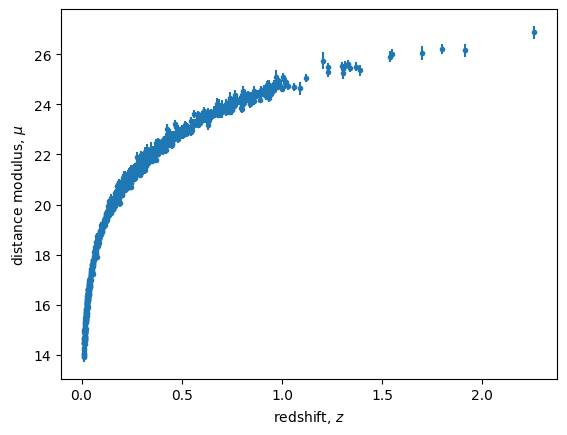

In [69]:
plt.errorbar(z,mB,yerr=err,fmt='.')
plt.xlabel(r'redshift, $z$')
plt.ylabel(r'distance modulus, $\mu$')

# Lets look how the matter component effects the distance modulus

/usr/local/lib/python3.10/dist-packages/astropy/cosmology/flrw/base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


Text(0, 0.5, 'distance modulus, $\\mu$')

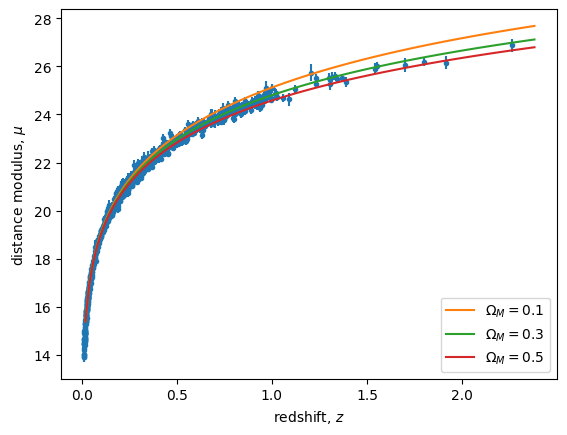

In [70]:
zs=np.arange(0,2.4,0.02)

plt.errorbar(z,mB,yerr=err,fmt='.',zorder=0)

cosmo = FlatLambdaCDM(Om0=0.1,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$\Omega_M=0.1$')

cosmo = FlatLambdaCDM(Om0=0.3,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$\Omega_M=0.3$')

cosmo = FlatLambdaCDM(Om0=0.5,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$\Omega_M=0.5$')
plt.legend(loc=4)

plt.xlabel(r'redshift, $z$')
plt.ylabel(r'distance modulus, $\mu$')

# Lets look how the dark energy equation of state, w, effects the distance modulus

Text(0, 0.5, 'distance modulus, $\\mu$')

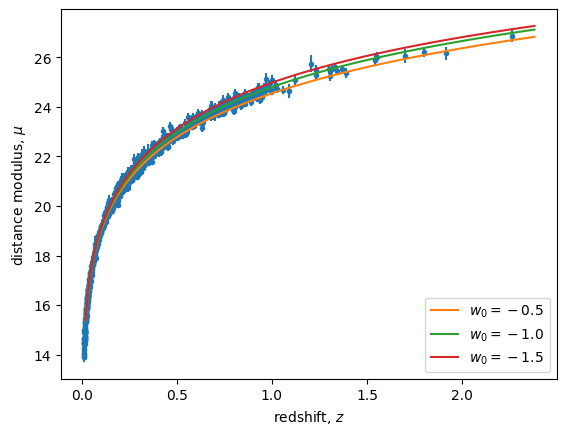

In [71]:
zs=np.arange(0,2.4,0.02)

plt.errorbar(z,mB,yerr=err,fmt='.',zorder=0)

cosmo = FlatwCDM(Om0=0.3,w0=-.5,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$w_0=-0.5$')

cosmo = FlatwCDM(Om0=0.3,w0=-1.,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$w_0=-1.0$')

cosmo = FlatwCDM(Om0=0.3,w0=-1.5,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$w_0=-1.5$')
plt.legend(loc=4)

plt.xlabel(r'redshift, $z$')
plt.ylabel(r'distance modulus, $\mu$')

# Plot the data covariance matrix

<ipython-input-72-df215f3a1a6b>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(Cov)))


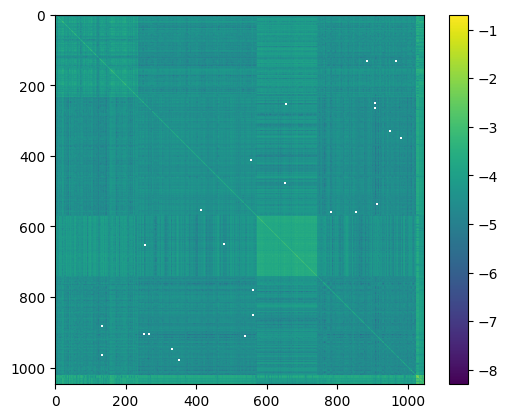

In [72]:
plt.imshow(np.log10(np.abs(Cov)))
plt.colorbar()

# Define the cost function (chi^2)

In [73]:
def residuals(params,model,data):
  '''return chi^2

  order: Om0, Ode0, w,Mb
  '''
  assert model in [0,1,2,3], 'error, model={} unknown'.format(model)
  H0 = 70.
  if model == 0:
    Om0,MB = params
    cosmo = FlatLambdaCDM(Om0=Om0,H0=H0)
  elif model == 1:
    # LCDM:
    Om0,Ode0,MB = params
    cosmo = LambdaCDM(Om0=Om0,Ode0=Ode0,H0=H0)
  elif model == 2:
    # flat wCDM
    Om0,w,MB = params
    cosmo = FlatwCDM(Om0=Om0,w0=w,H0=H0)
  elif model == 3:
    Om0,Ode0,w,MB = params
    cosmo = wCDM(Om0=Om0,Ode0=Ode0,w0=w,H0=H0)

  dy = cosmo.distmod(data['z']).value - (data['mB'] - MB )
  chi2 = dy.T @ Cinv @ dy

  return chi2


Use the genetic algorithm method to find the maximum likelihood point

In [134]:
# minimizing chi2 = max likelihood

Nparams = [2,3,3,4] # number of parameters in each model
bounds = {}
bounds[0] = ((0,1),(-21,-18))
bounds[1] = ((0,1),(0,1),(-21,-18))
bounds[2] = ((0,1),(-1.5,-0.5),(-21,-18))
bounds[3] = ((0,1),(0,1),(-1.5,-0.5),(-21,-18))
thetahat = {}
for model in range(4):
  print (72*"=")
  print(" Model: {}".format(model))
  res = optimize.differential_evolution(residuals,bounds=bounds[model],args=(model,data))
  #print (res)
  thetahat[model] = res.x
  chi2 = res.fun
  nu = Nsn-Nparams[model]
  print( " chi2/nu = {}/{} = {}".format(chi2,nu,chi2/nu))
  print(" best parameters = ",res.x)
  ii = df['Model'] == models[model]
  #print (ii,df.loc[ii])
  df.loc[ii,'AIC'] = chi2 + 2*Nparams[model]
  df.loc[ii,'BIC'] = chi2 + Nparams[model] * np.log(Nsn)
  df.loc[ii,'chi2min'] = chi2
  df.loc[ii,'chi2min/dof'] = chi2/nu

print (72*"=")
print (df)

 Model: 0
 chi2/nu = 1026.8618493062509/1046 = 0.9817034888205075
 best parameters =  [  0.29813848 -19.3497096 ]
 Model: 1
 chi2/nu = 1026.7149667355295/1045 = 0.9825023605124684
 best parameters =  [  0.32381426   0.74415395 -19.35293727]
 Model: 2
 chi2/nu = 1026.8108802917473/1045 = 0.9825941438198539
 best parameters =  [  0.31453494  -1.04728492 -19.35202413]
 Model: 3
 chi2/nu = 1026.4595290143257/1044 = 0.9831987825807716
 best parameters =  [  0.29534143   0.9541144   -0.8236455  -19.35097259]
      Model          AIC          BIC          DIC           Z      chi2min  \
0  FlatLCDM  1030.861849  1040.771127   1031.40554 -523.216569  1026.861849   
1      LCDM  1032.714967  1047.578883  1033.232227 -524.502628  1026.714967   
2  FlatwCDM   1032.81088  1047.674797  1029.116224 -524.583883   1026.81088   
3      wCDM  1034.459529  1054.278084  1003.957869 -524.917459  1026.459529   

  chi2min/dof  
0    0.981703  
1    0.982502  
2    0.982594  
3    0.983199  


# MCMC

In [75]:
# Define my priors:

def lnpOm0(Om0):
  if 0<Om0<1:
    return 0
  else:
    return -np.inf


def lnpMB(MB):
  ''' Note: this is an unnormalized prior.
  The correct normalization would be -np.log(Mb_Max-Mb_min) = np.log(1/(Mbmax-Mbmin))
  '''
  if -25<MB<-15:
    return 0
  else:
    return -np.inf

def lnpOde0(Ode0):
  if 0<Ode0<1.4:
    return 0
  else:
    return -np.inf

def lnpw(ww):
  if -3<ww<0:
    return 0
  else:
    return -np.inf

def lnprior(theta,model):
  '''Returns the (unnormalized) prior'''
  Om0 = theta[0]
  MB = theta[-1]
  lp = lnpOm0(Om0) + lnpMB(MB)
  if model in [1,3]:
    Ode0 = theta[1]
    lp += lnpOde0(Ode0)
  if model in [2,3]:
    ww = theta[-2]
    lp += lnpw(ww)
  return lp

def lnP(theta,model,data):
  '''Calculate the log posterior
  ln P(theta) = ln pi(theta) + ln L (theta)
  Also return the log likelihood as a blob.
  '''
  # 1. Get the prior for the parameters theta
  lp = lnprior(theta,model)

  # are the parameters within the priors?
  if np.isfinite (lp):
    # Get the log likelihood
    ll = -.5*residuals(theta,model,data)
    return lp+ll,ll
  else:
    # my prior is zero so I don't need to calculate ln L,
    # I just return ln pi = -inf
    return lp,lp


# Calculate the DIC

In [76]:
def DIC (mysample,thetamean):
  # ln L = -.5*residuals(theta,model,data)
  ll = mysample.get_blobs(flat=True,thin=nthin,discard=nburn).mean()
  # chi2(\bar\theta) = residuals = -2 ln L(\hat\theta)
  return -4*ll  - residuals(thetamean,model,data)


# Ok, now we run MCMC:

100%|██████████| 2000/2000 [02:13<00:00, 14.94it/s]


(780, 2)
[  0.29940334 -19.34925353]
1030.792248351633
      Model          AIC          BIC          DIC    Z      chi2min  \
0  FlatLCDM  1030.861849  1040.771127  1030.792248  NaN  1026.861849   
1      LCDM  1032.714968  1047.578885          NaN  NaN  1026.714968   
2  FlatwCDM   1032.81088  1047.674797          NaN  NaN   1026.81088   
3      wCDM  1034.457704  1054.276259          NaN  NaN  1026.457704   

  chi2min/dof  
0    0.981703  
1    0.982502  
2    0.982594  
3    0.983197  


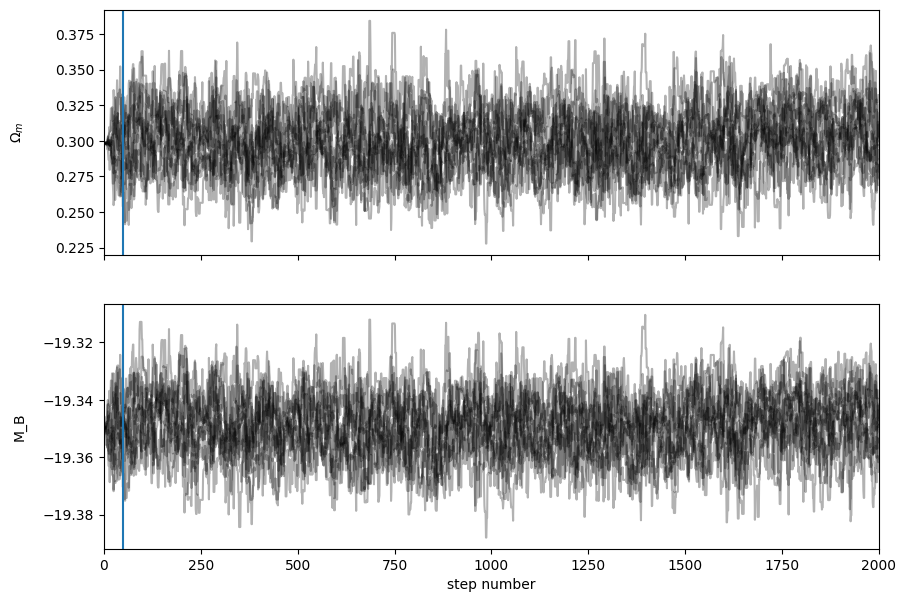

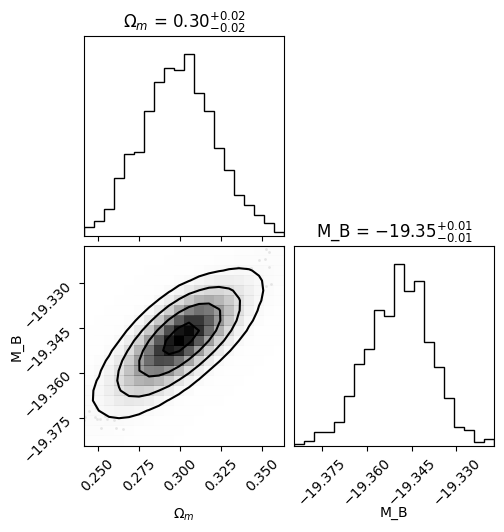

In [77]:
# fLCDM
model = 0
nwalker = 12
ndim = Nparams[model]
niter = 2000

theta0 = thetahat[model] + 1e-4 * np.random.randn(nwalker, ndim)
nwalkers, ndim = theta0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP, args=(model,data))
sampler.run_mcmc(theta0, niter, progress=True);



fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Omega_m$", r"M_B",]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.axvline(x=50)
axes[-1].set_xlabel("step number");

nburn = 50
nthin = 30

flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
print(flat_samples.shape)
thetamean = flat_samples.mean(axis=0)
print(thetamean)

fig = corner.corner(
    flat_samples, labels=labels, truth=thetahat, smooth=2.,show_titles=True
);

fig.savefig("flat_lcdm.pdf",dpi=600)

DIC_value = DIC(sampler,thetamean)
print (DIC_value)
df.loc[model,'DIC'] = DIC_value
print (df)

# Plot the data again with the best fit for flat LCDM (model 0)


/usr/local/lib/python3.10/dist-packages/astropy/cosmology/flrw/base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


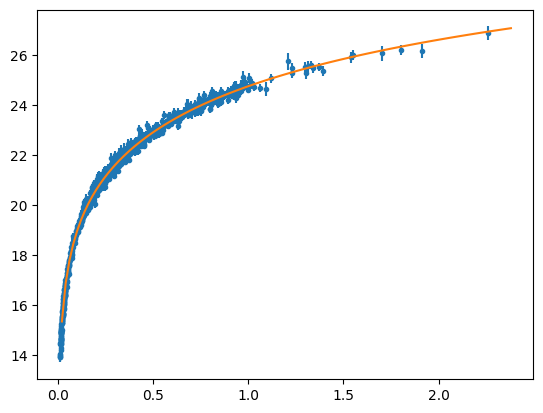

In [78]:
Om0,MB = thetamean
cosmo = FlatLambdaCDM(Om0=Om0,H0=70.0)
zs=np.arange(0,2.4,0.02)

dy = cosmo.distmod(zs).value + MB

plt.errorbar(z,mB,yerr=err,fmt='.',zorder=0)
plt.plot(zs,dy)

100%|██████████| 3000/3000 [02:52<00:00, 17.40it/s]


[37.17726789 41.9704527  46.01002447]
(1176, 3)
[  0.32140735   0.73909891 -19.3525912 ]
1032.5872779350027
      Model          AIC          BIC          DIC    Z      chi2min  \
0  FlatLCDM  1030.861849  1040.771127  1030.792248  NaN  1026.861849   
1      LCDM  1032.714968  1047.578885  1032.587278  NaN  1026.714968   
2  FlatwCDM   1032.81088  1047.674797          NaN  NaN   1026.81088   
3      wCDM  1034.457704  1054.276259          NaN  NaN  1026.457704   

  chi2min/dof  
0    0.981703  
1    0.982502  
2    0.982594  
3    0.983197  


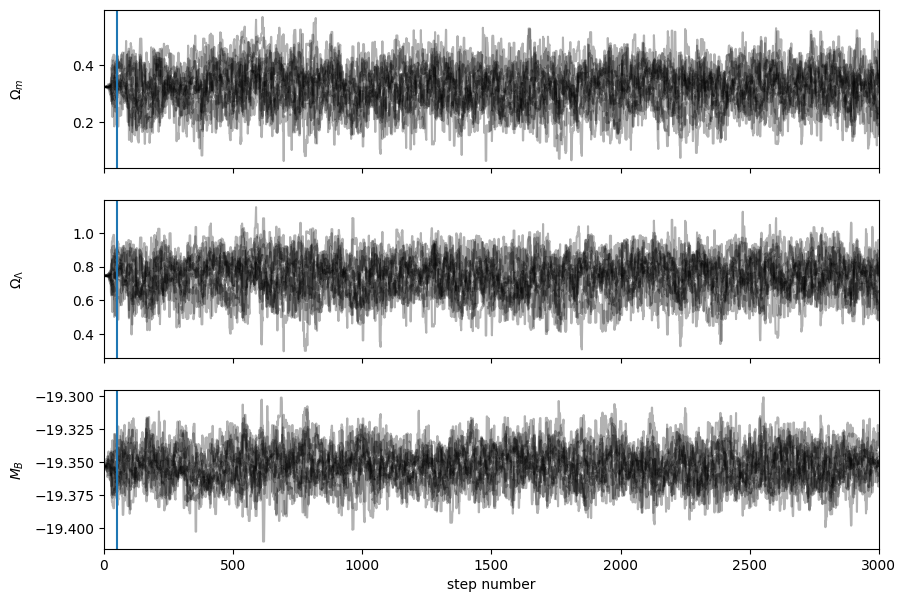

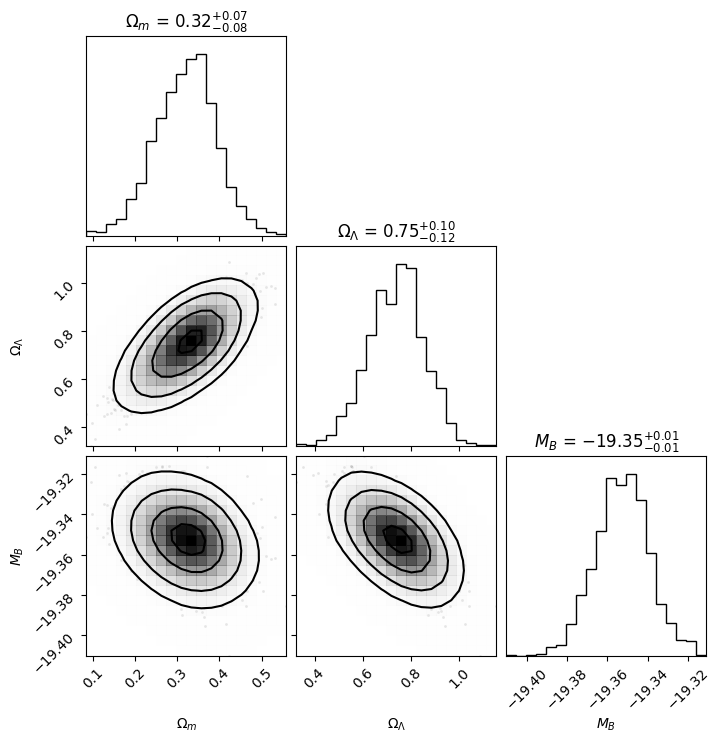

In [79]:
# LCDM
# initialize my MCMC:
model = 1
nwalker = 12
ndim = Nparams[model]
niter = 3000

# initial condition:
theta0 = thetahat[model] + 1e-4 * np.random.randn(nwalker, ndim)
nwalkers, ndim = theta0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP, args=(model,data))
sampler.run_mcmc(theta0, niter, progress=True);



fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Omega_m$", r"$\Omega_\Lambda$" ,r"$M_B$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.axvline(x=50)
axes[-1].set_xlabel("step number");

# AutocorrelatioN:
tau = sampler.get_autocorr_time()
print(tau)
nburn = 50 # remove the first nburn iterations
nthin = 30 # remove every nthin iteration to remove the correlation

flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
print(flat_samples.shape)
thetamean = flat_samples.mean(axis=0)
print(thetamean)


fig = corner.corner(
    flat_samples, labels=labels, truth=thetahat, smooth=2.,show_titles=True
);

fig.savefig("flat_lcdm.pdf",dpi=600)

DIC_value = DIC(sampler,thetamean)
print (DIC_value)
df.loc[model,'DIC'] = DIC_value
print (df)

In [145]:
# flatwCDM
model = 2
nwalker = 12
ndim = Nparams[model]
niter = 4000

theta0 = thetahat[model] + 1e-4 * np.random.randn(nwalker, ndim)
nwalkers, ndim = theta0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP, args=(model,data))
sampler.run_mcmc(theta0, niter, progress=True);



fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Omega_m$", r"$w$" ,r"$M_B$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.axvline(x=50)
axes[-1].set_xlabel("step number");

nburn = 50
nthin = 30

flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
print(flat_samples.shape)
thetamean = flat_samples.mean(axis=0)
print(thetamean)

fig = corner.corner(
    flat_samples, labels=labels, truth=thetahat, smooth=2.,show_titles=True
);

fig.savefig("flat_wcdm.pdf",dpi=600)

DIC_value = DIC(sampler,thetamean)
print (DIC_value)
df.loc[model,'DIC'] = DIC_value
print (df)

 53%|█████▎    | 2127/4000 [08:07<06:21,  4.91it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-75-00f7435bca89>", line 55, in lnP
    ll = -.5*residuals(theta,model,data)
  File "<ipython-input-73-427de352c34d>", line 23, in residuals
    dy = cosmo.distmod(data['z']).value - (data['mB'] - MB )
  File "/usr/local/lib/python3.10/dist-packages/astropy/cosmology/flrw/base.py", line 1343, in distmod
    val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
  File "/usr/local/lib/python3.10/dist-packages/astropy/cosmology/flrw/base.py", line 1261, in luminosity_distance
    return (z + 1.0) * self.comoving_transverse_distance(z)
  File "/usr/local/lib/python3.10/dist-packages/astropy/cosmology/flrw/base.py", line 1175, in comoving_transverse_distance
    return self._comoving_transverse_distance_z1z2(0, z)
  File "/usr/local/li

emcee: Exception while calling your likelihood function:
  params: [  0.25187548  -0.83486445 -19.33760619]
  args: (2, array([(0.50309, 22.93445, 0.12605), (0.4948 , 22.8802 , 0.11765),
       (0.67767, 24.0377 , 0.2056 ), ..., (1.014  , 24.85445, 0.2291 ),
       (1.315  , 25.54235, 0.1987 ), (1.092  , 24.63835, 0.26405)],
      dtype=[('z', '<f8'), ('mB', '<f8'), ('dmB', '<f8')]))
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# wCDM
model = 3
nwalker = 12
ndim = Nparams[model]
niter = 27000

theta0 = thetahat[model] + 1e-4 * np.random.randn(nwalker, ndim)
nwalkers, ndim = theta0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP, args=(model,data))
sampler.run_mcmc(theta0, niter, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Omega_m$", r"$\Omega_\Lambda$", r"$w$" ,r"$M_B$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.axvline(x=50)
axes[-1].set_xlabel("step number")

nburn = 50
nthin = 30

flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
print(flat_samples.shape)
thetamean = flat_samples.mean(axis=0)
print(thetamean)

fig = corner.corner(
    flat_samples, labels=labels, truth=thetahat, smooth=2.,show_titles=True
);

fig.savefig("wcdm.pdf",dpi=600)

DIC_value = DIC(sampler,thetamean)
print (DIC_value)
df.loc[model,'DIC'] = DIC_value
print (df)

# Now Setup Nested Sampling

In [135]:
def prior_transform(theta):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.
    Args:
        theta (tuple): a tuple containing the parameters.

    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """
    Om0 = theta[0]
    MB = theta[-1]
    Om0 = Om0*(bounds[model][0][1]-bounds[model][0][0]) + bounds[model][0][0]
    MB = MB*(bounds[model][-1][1]-bounds[model][-1][0]) + bounds[model][-1][0]

    if model == 0:
      theta = (Om0,MB)
    if model == 1:
      Ode0 = theta[1]
      Ode0 = Ode0*(bounds[model][1][1]-bounds[model][1][0]) + bounds[model][1][0]
      theta = (Om0,Ode0,MB)
    if model == 2:
      w0 = theta[1]
      w0 = w0*(bounds[model][1][1]-bounds[model][1][0]) + bounds[model][1][0]
      theta = (Om0,w0,MB)
    if model == 3:
      Ode0 = theta[1]
      Ode0 = Ode0*(bounds[model][1][1]-bounds[model][1][0]) + bounds[model][1][0]
      w0 = theta[2]
      w0 = w0*(bounds[model][2][1]-bounds[model][2][0]) + bounds[model][2][0]
      theta = (Om0,Ode0,w0,MB)

    return theta

def loglikelihood_dynesty(theta):
    """
    The log-likelihood function.
    """
    return -0.5 * residuals(theta,model,data)

In [136]:
model = 0

nlive = 100      # number of live points
bound = 'single'   # use MutliNest algorithm for bounds
ndims = 2         # two parameters
sample = 'unif'   # uniform sampling
tol = 0.05         # the stopping criterion


sampler = NestedSampler(loglikelihood_dynesty, prior_transform, ndims,
                        bound=bound, sample=sample, nlive=nlive)

sampler.run_nested(dlogz=tol, print_progress=True) # don't output progress bar


1156it [00:29, 39.81it/s, +100 | bound: 12 | nc: 1 | ncall: 5467 | eff(%): 23.402 | loglstar:   -inf < -513.431 <    inf | logz: -521.907 +/-  0.273 | dlogz:  0.000 >  0.050]


log(Z) = -521.9069397743103 ± 0.29876680565555314
      Model          AIC          BIC          DIC           Z      chi2min  \
0  FlatLCDM  1030.861849  1040.771127   1030.72544  -521.90694  1026.861849   
1      LCDM  1032.714967  1047.578883  1033.232227 -524.502628  1026.714967   
2  FlatwCDM   1032.81088  1047.674797  1029.116224 -524.583883   1026.81088   
3      wCDM  1034.459529  1054.278084  1003.957869 -524.917459  1026.459529   

  chi2min/dof  
0    0.981703  
1    0.982502  
2    0.982594  
3    0.983199  


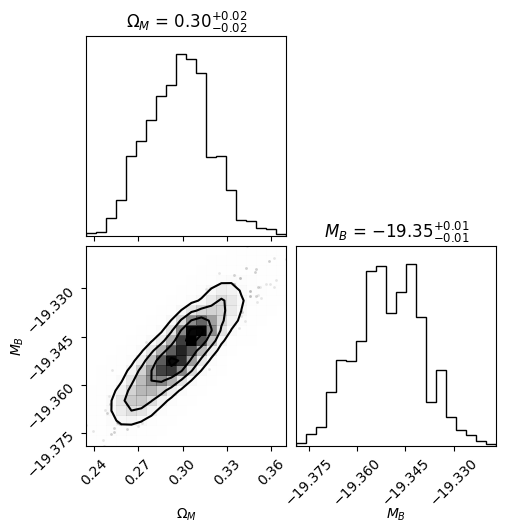

In [137]:
res = sampler.results # get results dictionary from sampler

logZdynesty = res.logz[-1]        # value of logZ
logZerrdynesty = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))

df.loc[model,'Z'] = logZdynesty


# draw posterior samples
weights = np.exp(res['logwt'] - res['logz'][-1])
samples_dynesty = resample_equal(res.samples, weights)

fig = corner.corner(
    samples_dynesty,  smooth=1.,show_titles=True,labels= ['$\Omega_M$','$M_B$']
);

# compute DIC from posterior samples
logls = res.logl
weights = np.exp(res['logwt'])
D_of_theta = -2.*logls
D_bar = np.average(D_of_theta, weights=weights)
theta_bar = np.average(res.samples, axis=0, weights=weights)
D_of_theta_bar = -2. * -0.5 *residuals(theta_bar,model,data)
p_D = D_bar - D_of_theta_bar
DIC_value = p_D + D_bar
df.loc[model,'DIC'] = DIC_value

print (df)

In [138]:
model = 1

nlive = 100      # number of live points
bound = 'single' # use MutliNest algorithm for bounds
ndims = 3        # three parameters
sample = 'unif'  # uniform sampling
tol = 0.05       # the stopping criterion


sampler = NestedSampler(loglikelihood_dynesty, prior_transform, ndims,
                        bound=bound, sample=sample, nlive=nlive)

sampler.run_nested(dlogz=tol, print_progress=True)


1233it [00:39, 31.09it/s, +100 | bound: 14 | nc: 1 | ncall: 5774 | eff(%): 23.493 | loglstar:   -inf < -513.371 <    inf | logz: -522.617 +/-  0.279 | dlogz:  0.000 >  0.050]


log(Z) = -522.6170601426812 ± 0.304218271232036
      Model          AIC          BIC          DIC           Z      chi2min  \
0  FlatLCDM  1030.861849  1040.771127   1030.72544  -521.90694  1026.861849   
1      LCDM  1032.714967  1047.578883  1032.790154  -522.61706  1026.714967   
2  FlatwCDM   1032.81088  1047.674797  1029.116224 -524.583883   1026.81088   
3      wCDM  1034.459529  1054.278084  1003.957869 -524.917459  1026.459529   

  chi2min/dof  
0    0.981703  
1    0.982502  
2    0.982594  
3    0.983199  


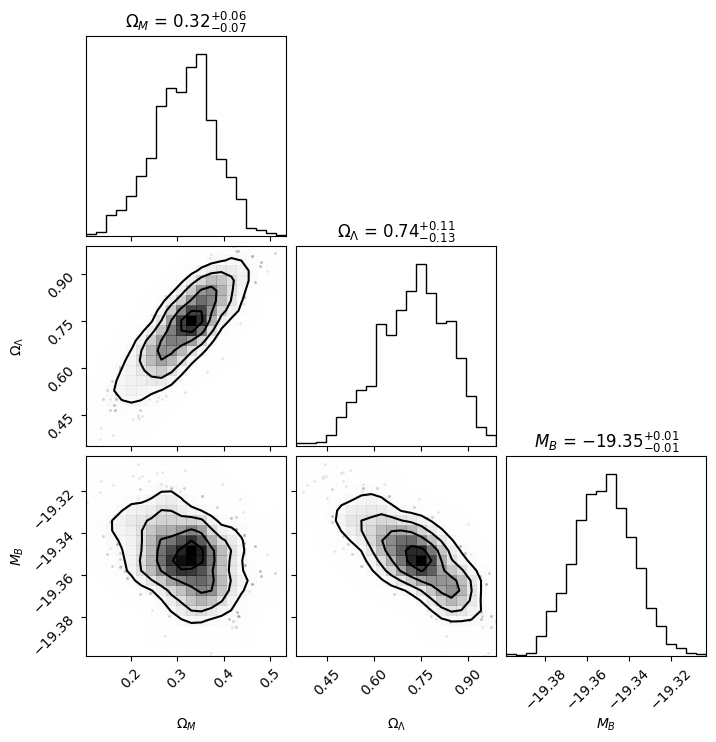

In [139]:
res = sampler.results # get results dictionary from sampler

logZdynesty = res.logz[-1]        # value of logZ
logZerrdynesty = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))

df.loc[model,'Z'] = logZdynesty


# draw posterior samples
weights = np.exp(res['logwt'] - res['logz'][-1])
samples_dynesty = resample_equal(res.samples, weights)

fig = corner.corner(
    samples_dynesty,  smooth=1.,show_titles=True,labels= ['$\Omega_M$','$\Omega_{\Lambda}$','$M_B$']
);

# compute DIC from posterior samples
logls = res.logl
weights = np.exp(res['logwt'])
D_of_theta = -2.*logls
D_bar = np.average(D_of_theta, weights=weights)
theta_bar = np.average(res.samples, axis=0, weights=weights)
D_of_theta_bar = -2. * -0.5 *residuals(theta_bar,model,data)
p_D = D_bar - D_of_theta_bar
DIC_value = p_D + D_bar
df.loc[model,'DIC'] = DIC_value

print (df)

In [142]:
model = 2

nlive = 100      # number of live points
bound = 'single'  # use MutliNest algorithm for bounds
ndims = 3        # three parameters
sample = 'unif'  # uniform sampling
tol = 0.01       # the stopping criterion


sampler = NestedSampler(loglikelihood_dynesty, prior_transform, ndims,
                        bound=bound, sample=sample, nlive=nlive,)

sampler.run_nested(dlogz=tol, print_progress=True)

1424it [03:42,  6.40it/s, +100 | bound: 51 | nc: 1 | ncall: 11784 | eff(%): 13.043 | loglstar:   -inf < -513.408 <    inf | logz: -522.967 +/-  0.284 | dlogz:  0.000 >  0.010]


log(Z) = -522.9665261931273 ± 0.2892763762026324
      Model          AIC          BIC          DIC           Z      chi2min  \
0  FlatLCDM  1030.861849  1040.771127   1030.72544  -521.90694  1026.861849   
1      LCDM  1032.714967  1047.578883  1032.790154  -522.61706  1026.714967   
2  FlatwCDM   1032.81088  1047.674797  1030.224934 -522.966526   1026.81088   
3      wCDM  1034.459529  1054.278084  1003.957869 -524.917459  1026.459529   

  chi2min/dof  
0    0.981703  
1    0.982502  
2    0.982594  
3    0.983199  


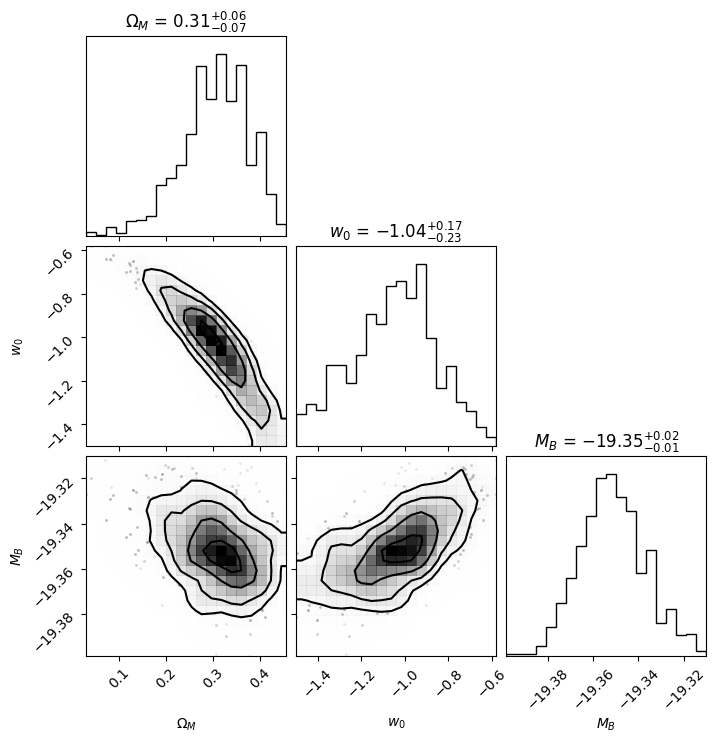

In [143]:
res = sampler.results # get results dictionary from sampler

logZdynesty = res.logz[-1]        # value of logZ
logZerrdynesty = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))

df.loc[model,'Z'] = logZdynesty


# draw posterior samples
weights = np.exp(res['logwt'] - res['logz'][-1])
samples_dynesty = resample_equal(res.samples, weights)

fig = corner.corner(
    samples_dynesty,  smooth=1.,show_titles=True,labels= ['$\Omega_M$','$w_0$','$M_B$']
);


# compute DIC from posterior samples
logls = res.logl
weights = np.exp(res['logwt'])
#weights = np.exp(res['logwt'] - res['logz'][-1])
D_of_theta = -2.*logls
D_bar = np.average(D_of_theta, weights=weights)
theta_bar = np.average(res.samples, axis=0, weights=weights)
D_of_theta_bar = -2. * -0.5 *residuals(theta_bar,model,data)
p_D = D_bar - D_of_theta_bar
DIC_value = p_D + D_bar
df.loc[model,'DIC'] = DIC_value

print (df)

In [120]:
model = 3

nlive = 100      # number of live points
bound = 'single'   # use MutliNest algorithm for bounds
ndims = 4         # four parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion


sampler = NestedSampler(loglikelihood_dynesty, prior_transform, ndims,
                        bound=bound, sample=sample, nlive=nlive)

sampler.run_nested(dlogz=tol, print_progress=True) # don't output progress bar

1408it [16:12,  1.45it/s, +100 | bound: 324 | nc: 1 | ncall: 52318 | eff(%):  2.888 | loglstar:   -inf < -513.242 <    inf | logz: -524.917 +/-  0.317 | dlogz:  0.001 >  0.100]


log(Z) = -524.9174591151414 ± 0.36748779626653433
      Model          AIC          BIC          DIC           Z      chi2min  \
0  FlatLCDM  1030.861849  1040.771127   1031.40554 -523.216569  1026.861849   
1      LCDM  1032.714968  1047.578885  1033.232227 -524.502628  1026.714968   
2  FlatwCDM   1032.81088  1047.674797  1029.082966 -524.461137   1026.81088   
3      wCDM  1034.457704  1054.276259  1003.957869 -524.917459  1026.457704   

  chi2min/dof  
0    0.981703  
1    0.982502  
2    0.982594  
3    0.983197  


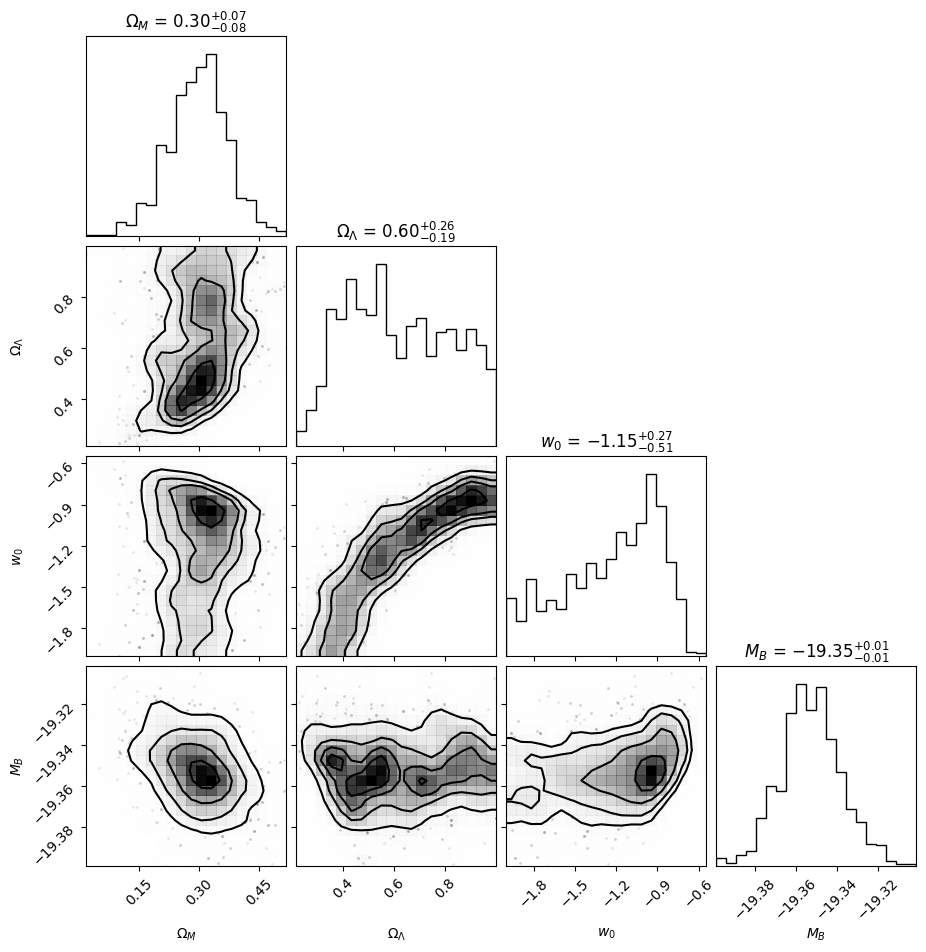

In [121]:
res = sampler.results # get results dictionary from sampler

logZdynesty = res.logz[-1]        # value of logZ
logZerrdynesty = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))

df.loc[model,'Z'] = logZdynesty


# draw posterior samples
weights = np.exp(res['logwt'] - res['logz'][-1])
samples_dynesty = resample_equal(res.samples, weights)

fig = corner.corner(
    samples_dynesty,  smooth=1.,show_titles=True,labels= ['$\Omega_M$','$\Omega_{\Lambda}$','$w_0$','$M_B$']
);

# compute DIC from posterior samples
logls = res.logl
weights = np.exp(res['logwt'])
D_of_theta = -2.*logls
D_bar = np.average(D_of_theta, weights=weights)
theta_bar = np.average(res.samples, axis=0, weights=weights)
D_of_theta_bar = -2. * -0.5 *residuals(theta_bar,model,data)
p_D = D_bar - D_of_theta_bar
DIC_value = p_D + D_bar
df.loc[model,'DIC'] = DIC_value

print (df)